**<center><font face="Times New Roman" size=6> Barrier Put Option (Down-and-Out) Pricing <center>**

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Binomial-Tree" data-toc-modified-id="Binomial-Tree-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Binomial Tree</a></span></li><li><span><a href="#Finite-Difference-Methods" data-toc-modified-id="Finite-Difference-Methods-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Finite Difference Methods</a></span><ul class="toc-item"><li><span><a href="#Explicit-Finite-Difference" data-toc-modified-id="Explicit-Finite-Difference-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Explicit Finite Difference</a></span></li><li><span><a href="#Implicit-Finite-Difference" data-toc-modified-id="Implicit-Finite-Difference-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Implicit Finite Difference</a></span></li></ul></li><li><span><a href="#Monte-Carlo-Similation" data-toc-modified-id="Monte-Carlo-Similation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Monte Carlo Similation</a></span></li><li><span><a href="#Comparison" data-toc-modified-id="Comparison-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Comparison</a></span></li></ul></div>

In [1]:
import numpy as np

import scipy.stats as si
from scipy.interpolate import interp1d
import scipy.linalg as la
import matplotlib.pyplot as plt

from BS_class import *

# %matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings('ignore')

In [2]:
S0 = 100
K = 105
r = 0.05
T = 0.5
sigma = 0.3
n = 100
H = 70
dS = 2
Smax = 150
dt = 1/1000

#  Binomial Tree

In [3]:
def binomialEuBarrierOption(S, K, r, T, sigma, n, H, option='call'):

    deltaT = T/n
    u = np.exp(sigma * np.sqrt(deltaT))
    d = 1.0 / u
    a = np.exp(r*deltaT)
    q = (a-d) / (u-d)
    Sv = np.zeros((n, n))
    V = np.zeros((n, n))

    for j in range(n):
        for i in range(j+1):
            Sv[i, j] = S * u**i * d**(j-i)
    if option == 'call':
        CorP = 1
    elif option == 'put':
        CorP = -1

    V[:, -1] = np.maximum((Sv[:, -1]-K)*CorP, 0)

    for j in reversed(range(n-1)):
        for i in range(j+1):
            if Sv[i, j+1] < H:
                V[i, j+1] = 0
            V[i, j] = np.exp(-r*deltaT)*(q*V[i+1, j+1]+(1.0-q)*V[i, j+1])

    return Sv, V, V[0, 0]

In [4]:
put_bin_bar = binomialEuBarrierOption(S0, K, r, T, sigma, n, H, option='put')
put_bin_bar_SV = put_bin_bar[0]
put_bin_bar_V = put_bin_bar[1]
put_bin_bar_price = put_bin_bar[2]

print('============================================')
print("Binomial European Barrier Put Price:", np.round(put_bin_bar_price, 4))
print('============================================')

Binomial European Barrier Put Price: 6.8479


# Finite Difference Methods

## Explicit Finite Difference

In [5]:
def EuBarrierPutEx(S, K, r, T, sigma, Smax, dS, dt, H): 
    
    M = np.int(np.round((Smax-H)/dS)) 
    dS = (Smax-H)/M 
    N = np.int(np.round(T/dt)) 
    dt = T/N 
    V = np.zeros((M+1,N+1))            
    Sv = np.linspace(H,Smax, M+1)      
    iv = Sv/dS                         
    jv = np.arange(N+1)                
    
    V[:,-1] = np.maximum(K-Sv,0)         
    V[0,:]  = 0                        
    V[M,:]  = 0                        
    
    a = 0.5*dt*((sigma**2)*iv - r)*iv 
    b = 1-dt*((sigma**2)*(iv**2) + r) 
    c = 0.5*dt*((sigma**2)*iv + r)*iv
    
    for j in reversed(np.arange(N)):                                  
        for i in np.arange(1,M):                                      
            V[i,j] = a[i]*V[i-1,j+1]+b[i]*V[i,j+1]+c[i]*V[i+1,j+1]
    
    f_interp = interp1d(Sv, V[:,0], kind = 'cubic')                    
    price = f_interp(S)                                               
    
    V[0,0] = 0
    return [Sv, V[:,0], price]

Price EFD: 6.7340


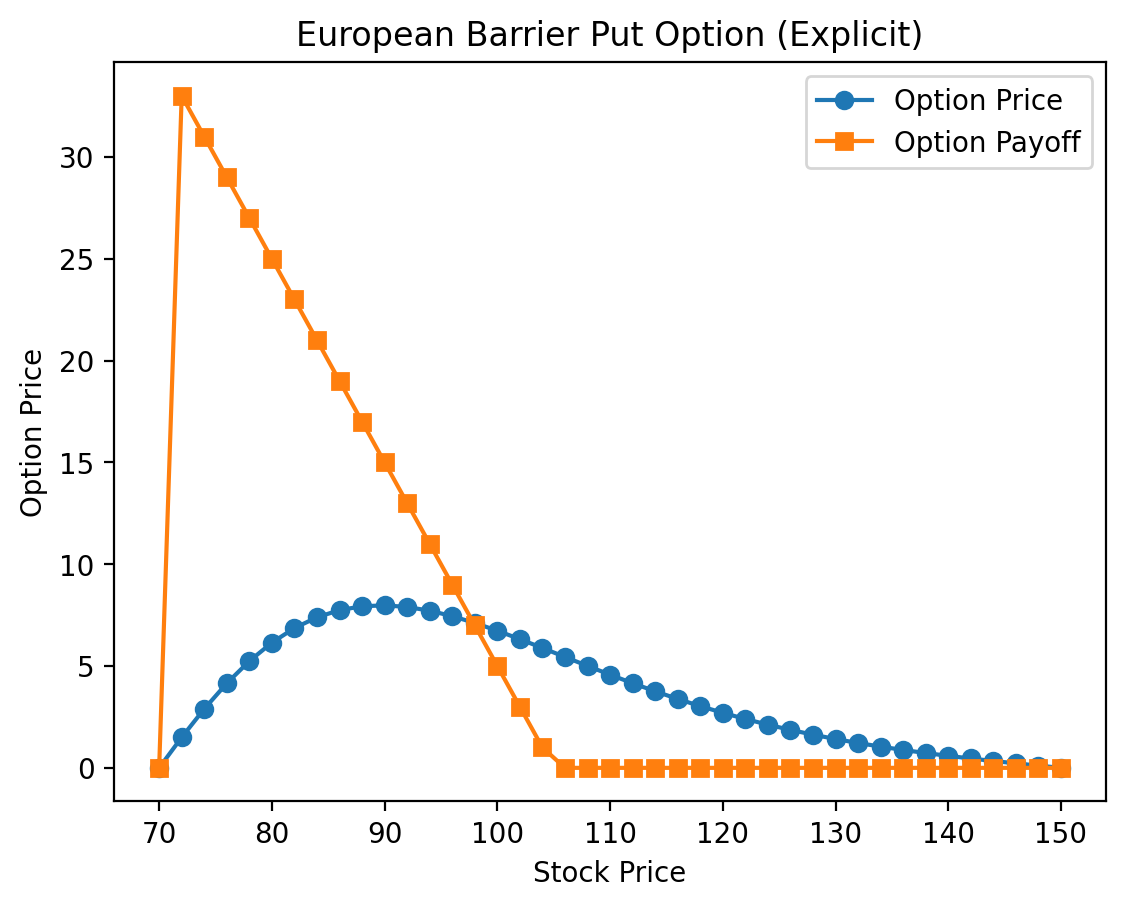

In [6]:
Put_Bar_EFD = EuBarrierPutEx(S0, K, r, T, sigma, Smax, dS, dt, H)

S_Bar_EFD = Put_Bar_EFD[0]
f_Bar_EFD = Put_Bar_EFD[1]
price_Bar_EFD = Put_Bar_EFD[2]

print('==================')
print('Price EFD:', '%.4f' % price_Bar_EFD)
print('==================')

payoff_Bar = []
for i in range(len(S_Bar_EFD)):
    if S_Bar_EFD[i] <= H:
        result = 0
    else:
        result = np.maximum(K-S_Bar_EFD[i], 0)
    payoff_Bar.append(result)

plt.plot(S_Bar_EFD, f_Bar_EFD, 'o-', label='Option Price')
plt.plot(S_Bar_EFD, payoff_Bar, 's-', label='Option Payoff')
plt.xlabel('Stock Price')
plt.ylabel('Option Price')
plt.title('European Barrier Put Option (Explicit)')
plt.legend()
plt.show()

## Implicit Finite Difference

In [7]:
def EuBarrierPutIm(S, K, r, T, sigma, Smax, dS, dt, H):

    M = np.int(np.round((Smax-H)/dS))
    dS = (Smax-H)/M
    N = np.int(np.round(T/dt))
    dt = T/N
    V = np.zeros((M+1, N+1))
    Sv = np.linspace(H, Smax, M+1)
    iv = Sv/dS
    jv = np.arange(N+1)
    
    V[:, -1] = np.maximum(K-Sv, 0)
    V[0, :] = 0
    V[M, :] = 0

    a = -0.5*dt*((sigma**2)*iv - r)*iv
    b = 1+dt*((sigma**2)*(iv**2) + r)
    c = -0.5*dt*((sigma**2)*iv + r)*iv
    
    coef_mat = np.diag(a[2:M], -1)+np.diag(b[1:M])+np.diag(c[1:M-1], 1)
    LU, P = la.lu_factor(coef_mat)
    bc = np.zeros(M-1)

    for j in reversed(np.arange(N)):
        bc[0] = -a[1]*V[0, j]
        bc[M-2] = -c[M-1]*V[M, j]
        V[1:M, j] = la.lu_solve((LU, P), V[1:M, j+1]+bc)

    f_interp = interp1d(Sv, V[:, 0], kind='cubic')
    price = f_interp(S)

    V[0, 0] = 0
    return [Sv, V[:, 0], price]

Price IFD: 6.7319


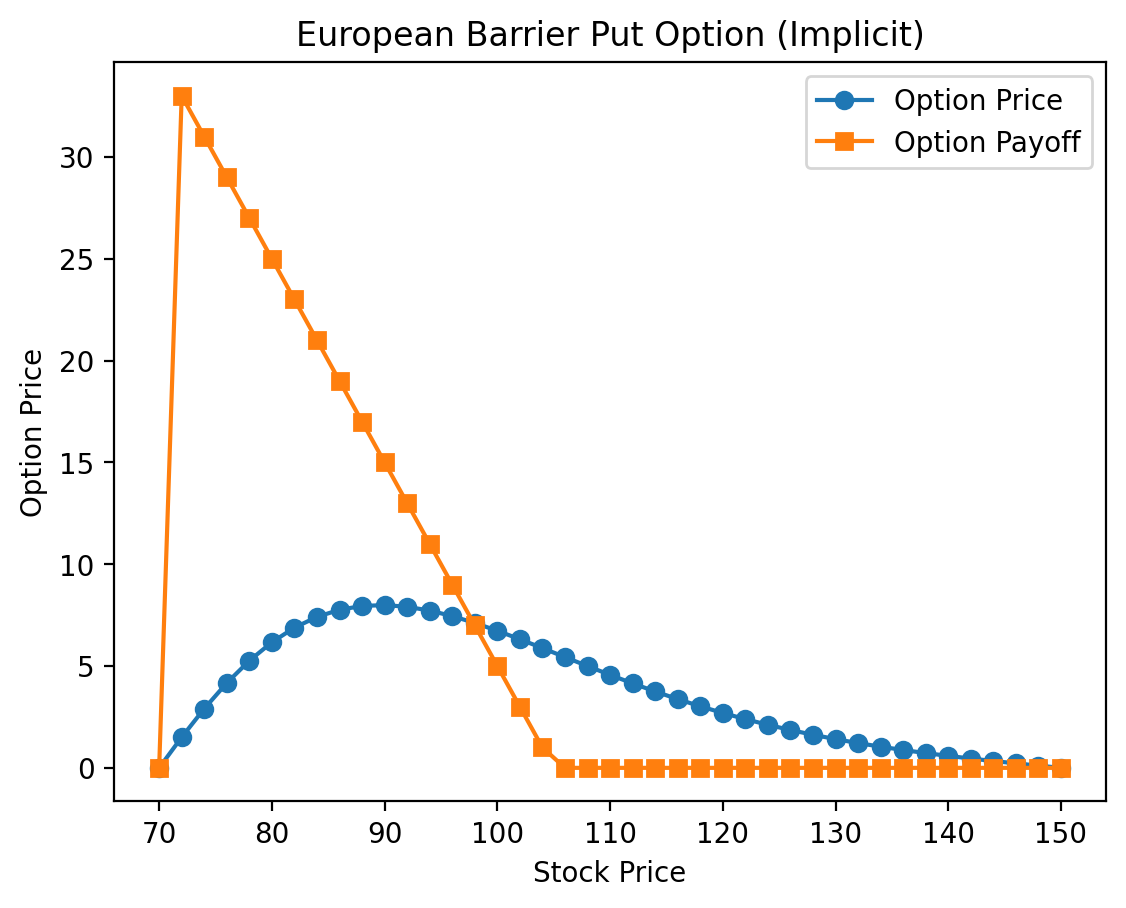

In [8]:
Put_Bar_IFD = EuBarrierPutIm(S0, K, r, T, sigma, Smax, dS, dt, H)

S_Bar_IFD = Put_Bar_IFD[0]
f_Bar_IFD = Put_Bar_IFD[1]
price_Bar_IFD = Put_Bar_IFD[2]

print('=================')
print('Price IFD:', '%.4f' %price_Bar_IFD)
print('=================')

payoff_Bar = []
for i in range(len(S_Bar_IFD)):
    if S_Bar_IFD[i] <= H:
        result = 0
    else:
        result = np.maximum(K-S_Bar_IFD[i], 0)
    payoff_Bar.append(result)

plt.plot(S_Bar_IFD, f_Bar_IFD, 'o-', label='Option Price')
plt.plot(S_Bar_IFD, payoff_Bar, 's-', label='Option Payoff')
plt.xlabel('Stock Price')
plt.ylabel('Option Price')
plt.title('European Barrier Put Option (Implicit)')
plt.legend()
plt.show()

# Monte Carlo Similation

In [9]:
def simulate_path(s0, mu, sigma, horizon, timesteps, n_sims):

    np.random.seed(2023)

    S0 = s0                 
    r = mu                  
    T = horizon             
    t = timesteps           
    n = n_sims              

    dt = T/t                

    S = np.zeros((t,n))
    S[0] = S0

    for i in range(0, t-1):
        w = np.random.standard_normal(n)
        S[i+1] = S[i] * (1 + r*dt + sigma*np.sqrt(dt)*w)

    return S

In [10]:
S0 = 100
K = 105
T = 0.5
r = 0.05
sigma = 0.30 

t = 100
Nsim = 100000

B = 70
rebate = 0
value = 0

S = simulate_path(S0, r, sigma, T, t, Nsim)

B_shift = B*np.exp(0.5826*sigma*np.sqrt(dt))

for i in range(Nsim):
    if S[:,i].min() > B_shift:
        value += np.maximum(0, K-S[-1,i])
    else:
        value += rebate

P0 = np.exp(-r*T) * value/Nsim

# Print the values 
print('=========================')
print('Price Monte Carlo:', '%.4f' % P0)
print('=========================')

Price Monte Carlo: 6.8645


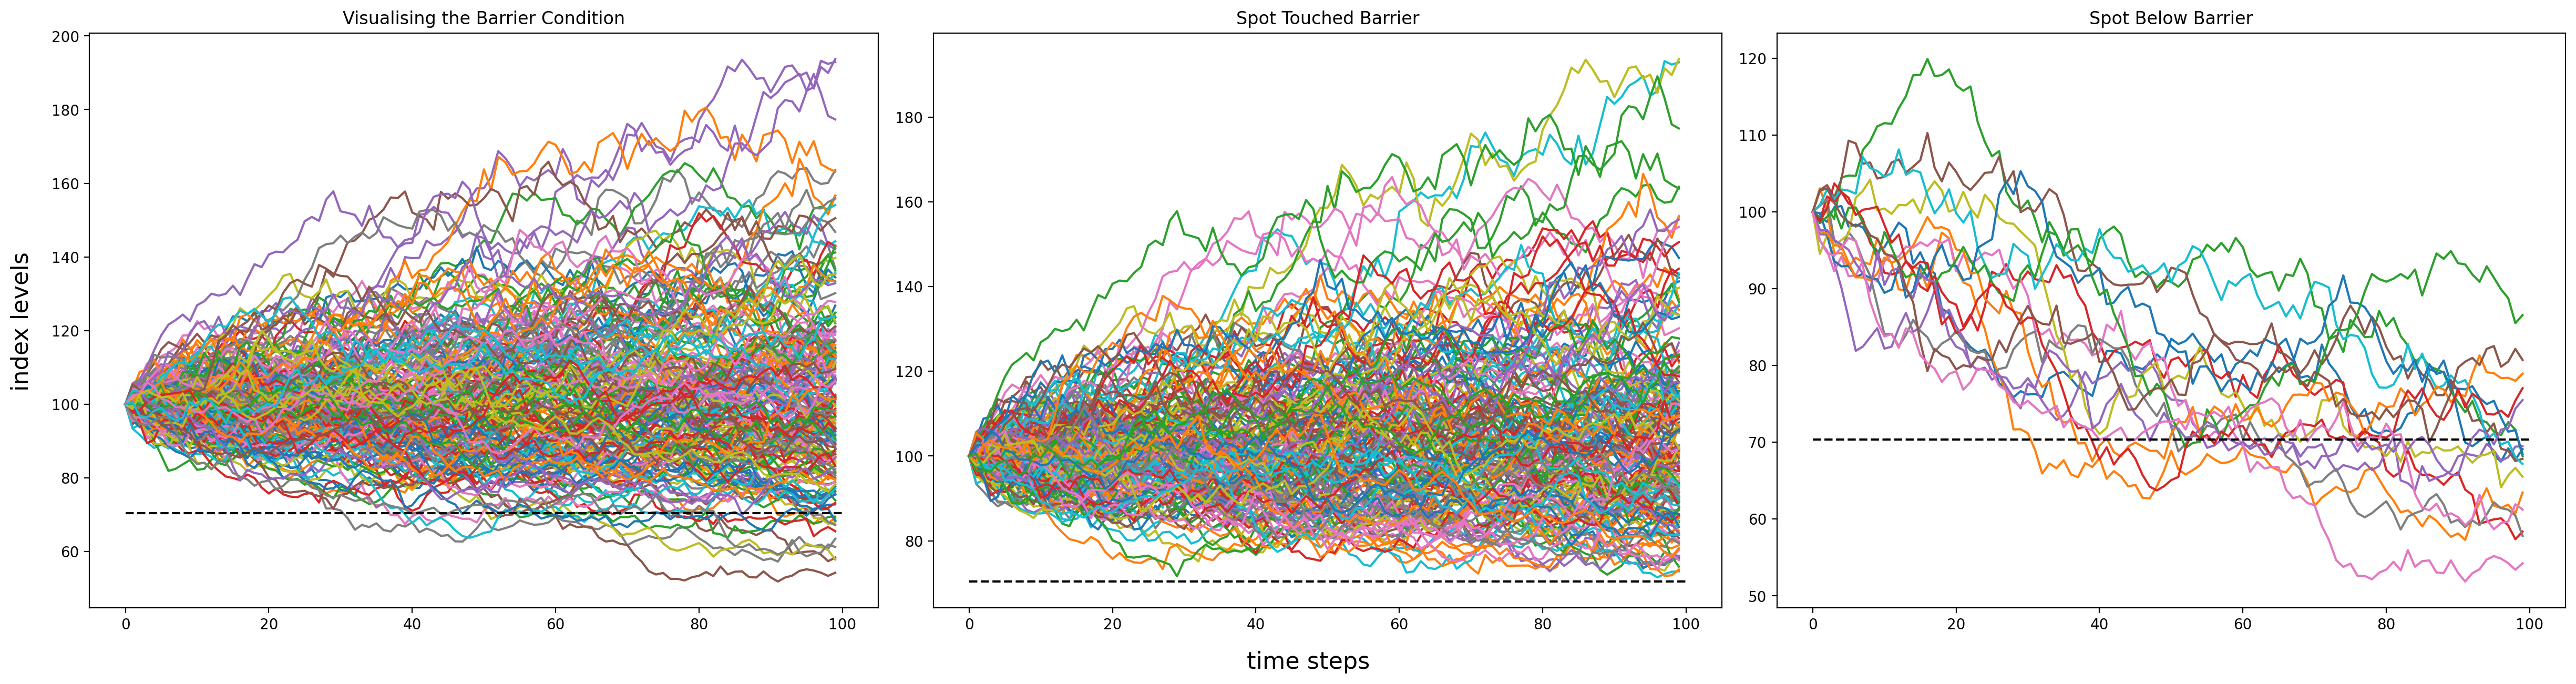

In [11]:
figure, axes = plt.subplots(1,3, figsize=(24,6), constrained_layout=True)
title = ['Visualising the Barrier Condition', 'Spot Touched Barrier', 'Spot Below Barrier']

axes[0].plot(S[:,:200])      
for i in range(200):
    axes[1].plot(S[:,i]) if S[:,i].min() > B_shift else axes[2].plot(S[:,i])

for i in range(3):
    axes[i].set_title(title[i])
    axes[i].hlines(B_shift, 0, 100, colors='k', linestyles='dashed')

figure.text(0.5, -0.04, 'time steps', ha='center', va='center', fontsize=16)
figure.text(-0.01, 0.5, 'index levels', ha='center', va='center', fontsize=16, rotation=90)

plt.show()

# Comparison

| <center>Methods                    | Option Price       |
| :--------------------------------- | -----------------: |
| Binomial Tree                      | 6.8479 |
| Explicit Finite Difference         | 6.7340 |
| Implicit Finite Difference         | 6.7319 |
| Monte Carlo Simulation             | 6.8645 |

**<center><font face="Times New Roman" size=6>🥳🥳🥳🥳🥳||END||🥳🥳🥳🥳🥳<center>**